**1 Discrete Cosine Transform (DCT)**

1.1  Derive a 4*4 DCT matrix starting from expressing the formula of 1-D DCT

1.2 

Given a 1-D signal of (2,−1,0,1)^T, obtain its DCT transformed signal.

**How would we compute the inverse transform of a given 1-D DCT transformed signal, in relation to the matrix form above?**

**2 Basic JPEG Compression**

In [1]:
from Utility import blockproc 
from PIL import Image 
from matplotlib.pyplot import imshow

import numpy as np 


In [ ]:
2.1 Optimal Color Space 


Image size (512, 768, 3)


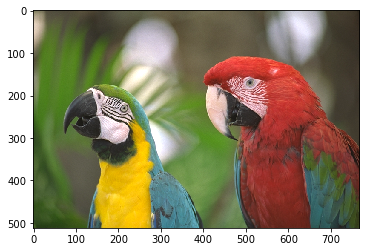

In [10]:
#1. Reading & showing input sample image, printing the size
birds = Image.open('birds.ppm')
imshow(birds)
print('Image size', np.array(birds).shape)


In [41]:
#2. rgb2ycber 
def rgb2ycber(img):
    """
    input: img (image array)
    output: ycbcr(transformed color space image array)
    """
    img_size = np.array(img).shape
    ycbcr = np.zeros(img_size)

    for i in range(img_size[0]):
        for j in range(img_size[1]):
            rgb2ycbcr_trans_mat = np.array ([[0.299,0.587,0.114],
            [-0.168736,-0.331264,0.5],
            [0.5,-0.418688,-0.081312]])            
            rgb_array = np.array([img[i,j,0], img[i,j,1], img[i,j,2]])
            ycbcr[i,j,:] += np.array([0,127.5,127.5]) + np.matmul(rgb2ycbcr_trans_mat, rgb_array)
            
    return ycbcr


In [45]:
# ycbcr2rgb 
def ycbcr2rgb(img):
    """
    input: img (image array)
    output: rgb(transformed color space image array)
    """
    img_size = np.array(img).shape
    rgb = np.zeros(img_size)

    for i in range(img_size[0]):
        for j in range(img_size[1]):
            rgb2ycbcr_trans_mat = np.linalg.inv(np.array ([[0.299,0.587,0.114],[-0.168736,-0.331264,0.5],[0.5,-0.418688,-0.081312]]))    #inverse matrix in this case 
            ycbcr_array = np.array([img[i,j,0], img[i,j,1], img[i,j,2]])  
            rgb[i,j,:] += np.matmul(rgb2ycbcr_trans_mat, ycbcr_array - np.array([0,127.5,127.5]) )
            
    return rgb

In [46]:
ycbcr_result = rgb2ycber(np.array(birds))
rgb_result = ycbcr2rgb(ycbcr_result)

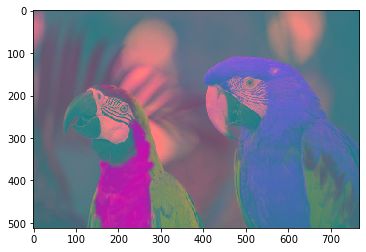

In [51]:
imshow(np.uint8(ycbcr_result))


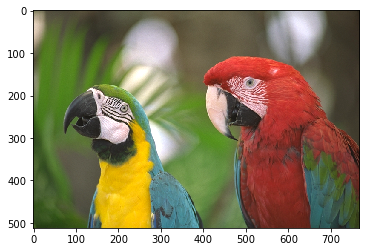

In [52]:
imshow(np.uint8(rgb_result))

**2.2 Downsample** 

In [ ]:
def downsample(inputmatrix, w):
    """
    input: (inputmatrix)given matrix which has to be downsampled
            W(blocksize)
    output: downsamp_mat
    """
    img_size = inputmatrix.shape
    downsamp_mat = np.zeros(img_size[0]//w, img_size[1]//w) #flooring operator instead of regular division to avoid fractional part
    block__image_avg = blockproc(inputmatrix, [w,w], np.mean)
    
    for i in range(0, img_size[0], w):
        for j in range(0, img_size[1], w):
            
            downsamp_mat[i//w,j//w] = block__image_avg[i, j]
            
    return downsamp_mat

In [ ]:
def upsample(inputmatrix, w):
    """
    input: (inputmatrix)given matrix which has to be upsampled
            W(blocksize)
    output: upsamp_mat
    """
    img_size = inputmatrix.shape
    upsamp_mat = np.zeros(img_size[0]*w, img_size[1]*w) 
    block__image_avg = blockproc(inputmatrix, [w,w], np.mean)
    
    for i in range(img_size[0]*w ): #-w+1 or -w 
        for j in range(img_size[1]*w):
            for k in range(w):
                for l in range(w):
                    #upsamp_mat[i*w,j*w] = block__image_avg[i//w, j//w] #will not give anything in interpolated data if we take i*w we need data between i - i*w too
                    upsamp_mat[i+k,j+k] = block__image_avg[i//w, j//w]

            
    return upsamp_mat

In [ ]:
downsampledimage = downsample(ycbcr_result,w=8)
imshow(np.uint8(downsampledimage))
downsampledimage.shape

In [ ]:
upsampledimage = upample(downsampledimage,w=8)
imshow(np.uint8(upsampledimage))
upsampledimage.shape

**2.3 DCT**
Transform all channels separately using DCT

In [ ]:
import from scipy.fftpack import dct, idct


In [ ]:
def dct2D(img):
    return dct(dct(img, norm='ortho').T, norm='ortho')

In [ ]:
def idct2D(img):
    return idct(idct(img, norm='ortho').T, norm='ortho')    


**2.4 Quantization**

Quantize image blocks

In [ ]:
def quanmat(img):
    q_mat = np.array([[8 ,19, 26, 29],
                [19,26,29,34],
                [22,27,32,40],
                [26,29,38,56]])
    img_size = inputmatrix.shape
    quant_matrix = np.zeros((img_size))
    for i in range(img_size[0]):
        for j in range(img_size[1]):
            quant_matrix[i,j] = img[i,j]//q_mat[i,j]
    return quant_matrix

In [ ]:
def dequanmat(img):
    q_mat = np.array([[8 ,19, 26, 29],
                [19,26,29,34],
                [22,27,32,40],
                [26,29,38,56]])
        
    invquant_matrix = np.zeros((img.shape))
    for i in range(img_size[0]):
        for j in range(img_size[1]): 
            invquant_matrix[i,j] = img[i,j]*q_mat[i,j]
                         
    return invquant_matrix

**2.5 Execution of DCT and Quantization**

In [ ]:
dct_y =  blockproc(ycbcr_result[:,:,0], [8,8], dct2D)
y_dash = blockproc(dct_y,[8,8],quanmat )

dct_cb =  blockproc(ycbcr_result[:,:,1], [8,8], dct2D)
cb_dash = blockproc(dct_cb,[8,8],quanmat )

dct_cr =  blockproc(ycbcr_result[:,:,2], [8,8], dct2D)
cr_dash = blockproc(dct_cr,[8,8],quanmat )



In [ ]:
#Display images

#original y channel 
imshow(np.uint8(ycbcr_result[:,:,0]))
axis('off')
title("original y channel")

#resulting y_dash

imshow(np.uint8(y_dash))
axis('off')
title("y_dash")

#difference between original y and y_dash

imshow(np.uint8(np.abs(ycbcr_result[:,:,0] - y_dash)))
axis('off')
title("difference between original y and y_dash")


**2.6 Encoding**

Huffmann coding on channels individually 

In [ ]:
from dahuffman import HuffmanCodec

In [ ]:
def encodemat(img):
    #flatten matrix into vector
    img_flatten = img.flatten()
    symbol, freq = np.unique(img, return_counts = True) #symbol and their frequency are provided in huffmancodec as dictionary as given in docs 
    #creating dict 

    huffmann_input_dict = {[i]: freq[i] 
    for i in range(len(symbol))}
    
    codec = HuffmanCodec.from_frequencies(huffmann_input_dict)
    encoded = codec.encode(img_flatten)
    
    return encoded, codec, img.shape

In [ ]:
def decodemat(img_encoded, codec, shape):
    
    decoded = codec.decode(img_encoded)
    decoded = np.array(decoded)
    
    return decoded.reshape(shape)

In [ ]:
encoded_y, codec_y, shape_y = encodemat(y_dash)
encoded_cb, codec_cb, shape_cb = encodemat(cb_dash)
encoded_cr, codec_cr, shape_cr = encodemat(cr_dash)

In [ ]:
# Lengths of the encoded channels:

print(len(encoded_y))
print(len(encoded_cb))
print(len(encoded_cr))

**2.7 Decompression**

